 # Chicago Health Equity Index: Data Engineering
   * Data is collected at the census tract level where possible. Various data features can be grouped into the following catagories: **Economic, Transportation, Education, and Safety**
   * Response feature is csv extract from the CDC: https://www.cdc.gov/nchs/data-visualization/life-expectancy/index.html# 
   * Model features are called via US Census API and SOCRATA API via City of Chicago Data Portal

   * Census data collected from the API of the ACS 5 year from 2015 at the data profile level: Data Dictionary can be found here: https://api.census.gov/data/2015/acs/acs5/profile/variables.html

   * Additional Census Data can be added from the detailed tables here: https://www.census.gov/data/developers/data-sets/acs-5year.html
        * **Detailed Tables** contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population counts. There are over 20,000 variables in this dataset.
        * **Subject Tables** provide an overview of the estimates available in a particular topic.  The data are presented as population counts and percentages.  There are over 18,000 variables in this dataset. 
        * **Data Profiles** contain broad social, economic, housing, and demographic information. The data are presented as population counts and percentages. There are over 1,000 variables in this dataset.
        * **Comparison Profiles** are similar to Data Profiles but also include comparisons with past-year data.  The current year data are compared with prior 5-Year data and include statistical significance testing.  There are over 1,000 variables in this dataset.

## Import Libraries, Functions, and Flat Files

In [305]:
#Import Libraries
from secrets import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from census import Census
from us import states
from datetime import datetime
from sodapy import Socrata

In [306]:
#Import Flat Files
life_expectancy = pd.read_csv('LifeExp.csv')
chicago_tracts=pd.read_csv('Chicago_Tracts.csv')

In [308]:
#Define API Call Functions

    #Chicago Constants
chicago_url='data.cityofchicago.org'
cdp=Socrata(chicago_url, cdp_key)

def callCDP(root: str, filter: str) -> pd.DataFrame:
    results = cdp.get(root, query=filter)
    df=pd.DataFrame.from_records(results)
    return df


def get_census_dp(variables,year=2015):
    c=Census(census_key, year=year)
    # Get the ACS data
    variable_codes=list(variables.values())
    variable_codes.append('NAME')
    data = c.acs5dp.state_county_tract(variable_codes, states.IL.fips, '031', Census.ALL)
    
    # Convert to DataFrame
    census_df = pd.DataFrame(data)
    census_df['tract']=census_df['tract'].astype(int)
    census_df['tract']=census_df['tract'].astype(str)
    
    # Rename columns based on the variable_map keys
    reverse_map = {v: k for k, v in variables.items()}  # Reverse the mapping for renaming
    census_df.rename(columns=reverse_map, inplace=True)

    return census_df

def get_census_dt(variable_codes):
    # Get the ACS data
    variable_codes.append('NAME')
    data = c.acs5.state_county_tract(variable_codes, states.IL.fips, '031', Census.ALL)
    
    # Convert to DataFrame
    census_df = pd.DataFrame(data)
    census_df['tract']=census_df['tract'].astype(int)
    census_df['tract']=census_df['tract'].astype(str)
    
    return census_df

In [309]:
# Example usage
variables= {
    'Insured_Pe': 'DP03_0096PE',
    'NonInsured_Pe': 'DP03_0099PE'
}

df_test=get_census_dp(variables)
df_test.head()

,Insured_Pe,NonInsured_Pe,NAME,state,county,tract
0,86.2,13.8,"Census Tract 2714, Cook County, Illinois",17,031,271400
1,96.4,3.6,"Census Tract 2801, Cook County, Illinois",17,031,280100
2,83.2,16.8,"Census Tract 8235, Cook County, Illinois",17,031,823500
3,86.5,13.5,"Census Tract 8215, Cook County, Illinois",17,031,821500
4,94.2,5.8,"Census Tract 8218, Cook County, Illinois",17,031,821800


## Response Variables: Length of Life and Quality of Life

In [310]:
life_expectancy = life_expectancy[(life_expectancy['State'] == 'Illinois') & (life_expectancy['County'].str.contains('Cook'))]

In [311]:
life_expectancy['Tract'] = life_expectancy['Census Tract Number']
life_expectancy['Tract'] = life_expectancy['Tract']*100
life_expectancy['tract'] = life_expectancy['Tract'].astype(int).astype(str)
life_expectancy.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,Tract,tract
21114,Illinois,"Cook County, IL",101.00,68.8,56.9-75.1,1.7306,10100.0,10100
21115,Illinois,"Cook County, IL",102.01,77.3,75.2-77.5,1.9253,10201.0,10201
21116,Illinois,"Cook County, IL",102.02,78.6,77.6-79.5,1.3567,10202.0,10202
21117,Illinois,"Cook County, IL",103.00,70.0,56.9-75.1,1.0274,10300.0,10300
21118,Illinois,"Cook County, IL",104.00,79.7,79.6-81.6,1.9647,10400.0,10400


### Filter Response to Only Chicago Tracts

In [315]:
chicago_tracts['tract']=chicago_tracts['TRACTCE10']
chicago_tracts['tract']=chicago_tracts['tract'].astype(str)

In [316]:
life_expectancy = pd.merge(life_expectancy,chicago_tracts, on='tract', how='inner')
life_expectancy.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,Tract,tract,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood
0,Illinois,"Cook County, IL",101.00,68.8,56.9-75.1,1.7306,10100.0,10100,MULTIPOLYGON (((-87.66368000002299 42.01939800...,17,31,10100,17031010100,101.00,Census Tract 101,1,ROGERS PARK
1,Illinois,"Cook County, IL",102.01,77.3,75.2-77.5,1.9253,10201.0,10201,MULTIPOLYGON (((-87.6800950000417 42.012537999...,17,31,10201,17031010201,102.01,Census Tract 102.01,1,ROGERS PARK
2,Illinois,"Cook County, IL",102.02,78.6,77.6-79.5,1.3567,10202.0,10202,MULTIPOLYGON (((-87.67335799998422 42.01937400...,17,31,10202,17031010202,102.02,Census Tract 102.02,1,ROGERS PARK
3,Illinois,"Cook County, IL",103.00,70.0,56.9-75.1,1.0274,10300.0,10300,MULTIPOLYGON (((-87.66505999995483 42.01280100...,17,31,10300,17031010300,103.00,Census Tract 103,1,ROGERS PARK
4,Illinois,"Cook County, IL",104.00,79.7,79.6-81.6,1.9647,10400.0,10400,MULTIPOLYGON (((-87.65080299995667 41.99848500...,17,31,10400,17031010400,104.00,Census Tract 104,1,ROGERS PARK


### Test Join on Tract Level

In [259]:
merge_df=pd.merge(df_test, life_expectancy, on='tract', how='inner')
merge_df.head()

,DP05_0001E,NAME,state,county,tract,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,...,Tract,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood
0,1185.0,"Census Tract 2714, Cook County, Illinois",17,031,271400,Illinois,"Cook County, IL",2714.0,68.6,56.9-75.1,...,271400.0,MULTIPOLYGON (((-87.71080299996187 41.87426299...,17,31,271400,17031271400,2714.0,Census Tract 2714,27,EAST GARFIELD PARK
1,6811.0,"Census Tract 2801, Cook County, Illinois",17,031,280100,Illinois,"Cook County, IL",2801.0,NaN,NaN,...,280100.0,MULTIPOLYGON (((-87.64571900003747 41.88179600...,17,31,280100,17031280100,2801.0,Census Tract 2801,28,NEAR WEST SIDE
2,1673.0,"Census Tract 3103, Cook County, Illinois",17,031,310300,Illinois,"Cook County, IL",3103.0,79.1,77.6-79.5,...,310300.0,MULTIPOLYGON (((-87.64926400002443 41.85259500...,17,31,310300,17031310300,3103.0,Census Tract 3103,31,LOWER WEST SIDE
3,4815.0,"Census Tract 2002, Cook County, Illinois",17,031,200200,Illinois,"Cook County, IL",2002.0,78.5,77.6-79.5,...,200200.0,MULTIPOLYGON (((-87.74165199997601 41.93159800...,17,31,200200,17031200200,2002.0,Census Tract 2002,20,HERMOSA
4,3034.0,"Census Tract 2214, Cook County, Illinois",17,031,221400,Illinois,"Cook County, IL",2214.0,80.9,79.6-81.6,...,221400.0,MULTIPOLYGON (((-87.69738199997865 41.92358800...,17,31,221400,17031221400,2214.0,Census Tract 2214,22,LOGAN SQUARE


## Feature List

In [ ]:
features= {
'Population': 'DP05_0001E',
'Poverty': 'DP03_0119PE',
'Income': 'DP03_0066E',
'Unemployment': 'DP03_0009PE',
'Education': 'DP02_0066PE',
'Healthcare': 'DP03_0099PE',
'Insurance': 'DP03_0096PE',
}

In [335]:
features = {
    'Labor Force': 'DP03_0002E',  # Population 16+ in labor force
    'Unemployed': 'DP03_0005E',  # Unemployed population 16+ in civilian labor force
    'Family Poverty': 'DP03_0119PE',  # % Families below poverty level
    'HS Graduates': 'DP02_0061E',  # Population 25+ with high school diploma
    'Bachelors Degree': 'DP02_0064E',  # Population 25+ with bachelor's degree
    'Grad/Prof Degree': 'DP02_0065E',  # Population 25+ with graduate or professional degree
    'Private Health Ins': 'DP03_0097E',  # Population with private health insurance
    'Public Health Ins': 'DP03_0098E',  # Population with public health insurance
    'No Health Ins': 'DP03_0099E',  # Population without health insurance
    'No Vehicles': 'DP04_0058E',  # Households with no vehicles
    'One Vehicle': 'DP04_0059E',  # Households with 1 vehicle
    'Two Vehicles': 'DP04_0060E',  # Households with 2 vehicles
    'Three+ Vehicles': 'DP04_0061E',  # Households with 3+ vehicles
    'Drive Alone': 'DP03_0019PE',  # Commute by driving alone
    'Carpooled': 'DP03_0020E',  # Commute by carpooling
    'Public Transit': 'DP03_0021E',  # Commute by public transportation
    'Total Population': 'DP02_0122E',  # Total population by ancestry
    'Male':'DP05_0002E',
    'Female':'DP05_0003E'
}


## Call API Data

In [336]:
features_df=get_census_dp(features)
features_df.head()

,Labor Force,Unemployed,Family Poverty,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,...,Drive Alone,Carpooled,Public Transit,Total Population,Male,Female,NAME,state,county,tract
0,456.0,80.0,43.3,182.0,77.0,21.0,357.0,697.0,163.0,130.0,...,31.0,31.0,154.0,1185.0,615.0,570.0,"Census Tract 2714, Cook County, Illinois",17,031,271400
1,5892.0,174.0,0.0,226.0,2927.0,2367.0,6417.0,322.0,247.0,1313.0,...,25.4,200.0,800.0,6811.0,3355.0,3456.0,"Census Tract 2801, Cook County, Illinois",17,031,280100
2,2447.0,414.0,13.3,1033.0,354.0,279.0,2639.0,1697.0,773.0,177.0,...,69.8,329.0,173.0,4643.0,2307.0,2336.0,"Census Tract 8235, Cook County, Illinois",17,031,823500
3,812.0,167.0,27.4,368.0,92.0,28.0,728.0,1010.0,250.0,148.0,...,67.5,26.0,130.0,1858.0,800.0,1058.0,"Census Tract 8215, Cook County, Illinois",17,031,821500
4,3100.0,314.0,4.5,948.0,703.0,427.0,4461.0,1075.0,314.0,174.0,...,74.1,252.0,274.0,5369.0,2514.0,2855.0,"Census Tract 8218, Cook County, Illinois",17,031,821800


## Joined Model and Export

In [337]:
#merge
model=pd.merge(features_df, life_expectancy, on='tract', how='inner')
model.head()

,Labor Force,Unemployed,Family Poverty,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,...,Tract,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood
0,456.0,80.0,43.3,182.0,77.0,21.0,357.0,697.0,163.0,130.0,...,271400.0,MULTIPOLYGON (((-87.71080299996187 41.87426299...,17,31,271400,17031271400,2714.0,Census Tract 2714,27,EAST GARFIELD PARK
1,5892.0,174.0,0.0,226.0,2927.0,2367.0,6417.0,322.0,247.0,1313.0,...,280100.0,MULTIPOLYGON (((-87.64571900003747 41.88179600...,17,31,280100,17031280100,2801.0,Census Tract 2801,28,NEAR WEST SIDE
2,1126.0,162.0,14.2,194.0,326.0,145.0,828.0,398.0,525.0,152.0,...,310300.0,MULTIPOLYGON (((-87.64926400002443 41.85259500...,17,31,310300,17031310300,3103.0,Census Tract 3103,31,LOWER WEST SIDE
3,2440.0,277.0,26.9,1031.0,204.0,78.0,1578.0,2357.0,1053.0,375.0,...,200200.0,MULTIPOLYGON (((-87.74165199997601 41.93159800...,17,31,200200,17031200200,2002.0,Census Tract 2002,20,HERMOSA
4,2048.0,74.0,12.7,479.0,627.0,312.0,1929.0,448.0,733.0,280.0,...,221400.0,MULTIPOLYGON (((-87.69738199997865 41.92358800...,17,31,221400,17031221400,2214.0,Census Tract 2214,22,LOGAN SQUARE


In [324]:
#export
final_model=model
final_model.to_csv('final_model.csv')

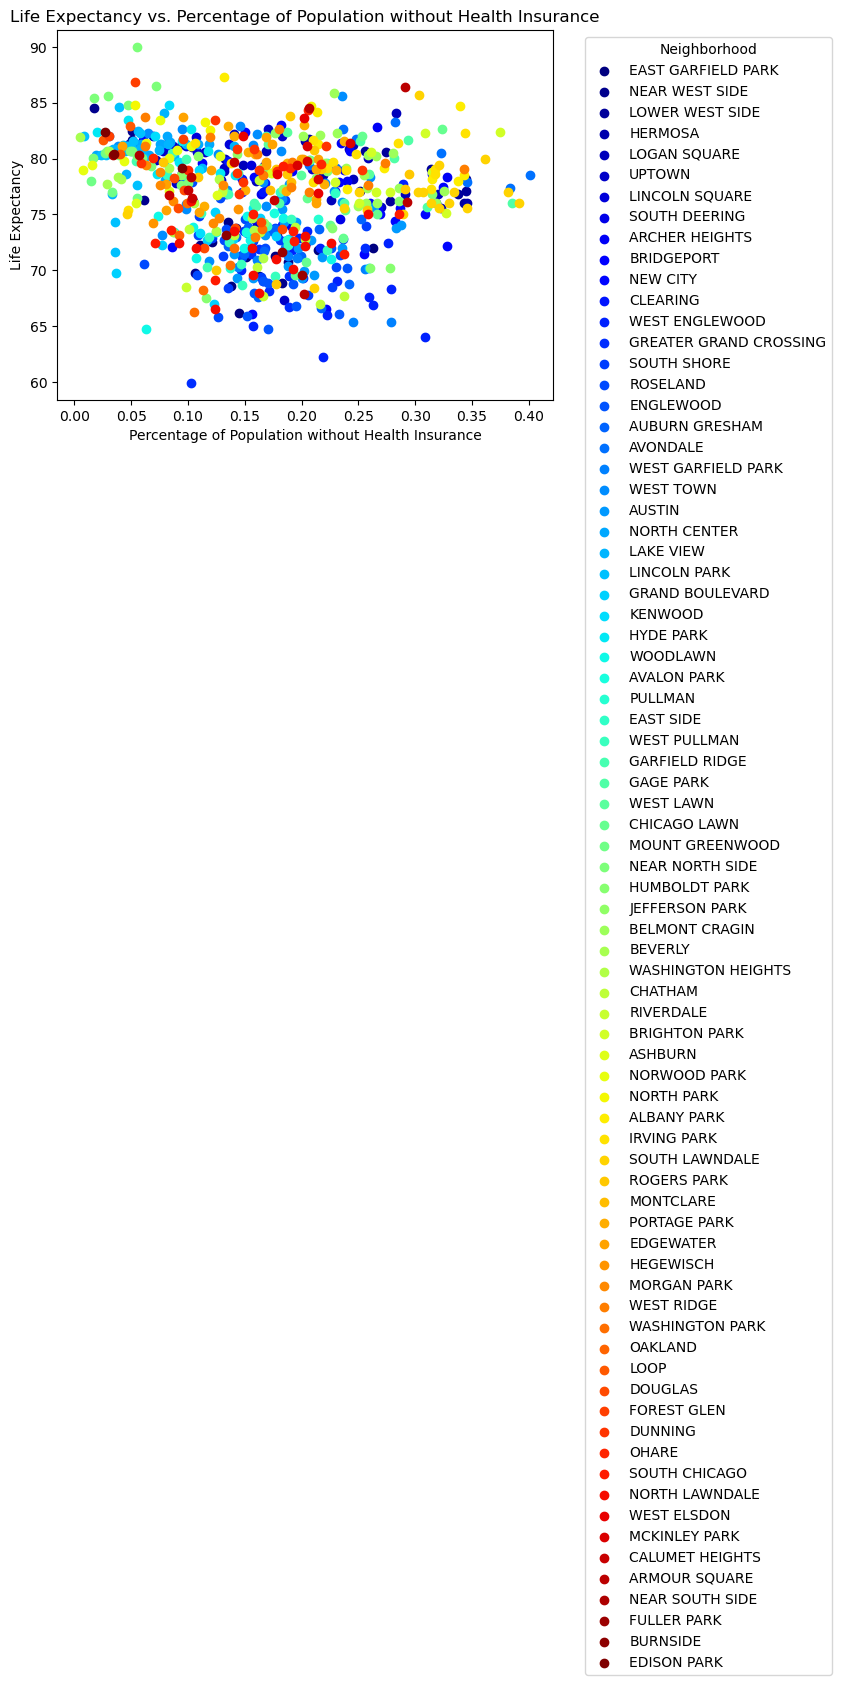

In [334]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Neighborhood' is a column in your final_model DataFrame
# and it contains categorical data representing different neighborhoods

# Map each unique neighborhood to a color
unique_neighborhoods = final_model['neighborhood'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_neighborhoods)))
neighborhood_colors = {neighborhood: color for neighborhood, color in zip(unique_neighborhoods, colors)}

# Scatter plot
for neighborhood in unique_neighborhoods:
    subset = final_model[final_model['neighborhood'] == neighborhood]
    plt.scatter(subset['No Health Ins'] / subset['Total Population'], subset['Life Expectancy'], 
                color=neighborhood_colors[neighborhood], label=neighborhood)

plt.xlabel('Percentage of Population without Health Insurance')
plt.ylabel('Life Expectancy')
plt.title('Life Expectancy vs. Percentage of Population without Health Insurance')
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


## Economic Features

In [ ]:
#Household Income: DP03_0062E
#Rent Burden (DP04_0134E/(DP03_0062E/12)
#Poverty Rate: DP03_128PE


#Unemployment Rate 
#Number of Births

## Education Features

In [ ]:
#Bachelor Obtaiment: DP02_0065PE



## Safety Features

In [ ]:
#Amount of crime in area
#Size of household
#Number of Dependents


## Transportation Features

In [ ]:
#Number of Cars per household
#mode of transportation to work